# gpOptimizer: Single-Task

In [1]:
## First, install the right version of gpCAM, and matplotlib
#!pip install gpcam==8.3.5
#!pip install matplotlib

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time
from distributed import Client
client = Client()

%load_ext autoreload
%autoreload 2

/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34705 instead
  warnings.warn(


In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data Prep

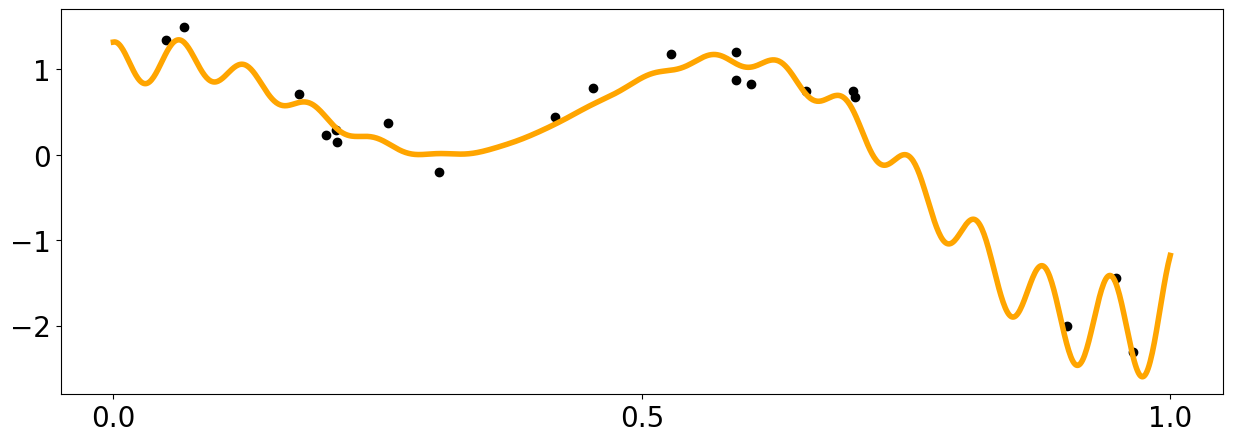

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(20).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing the Gaussian Process

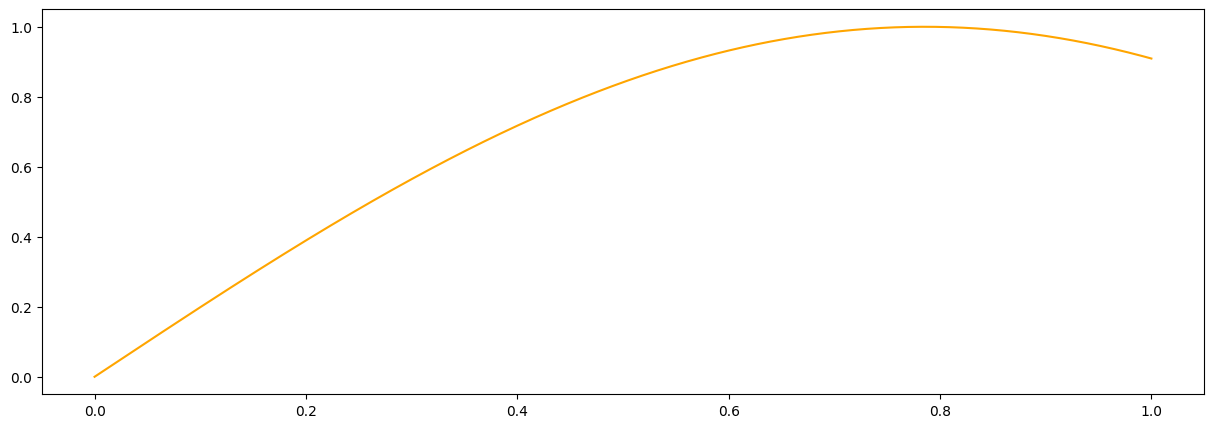

In [5]:
from gpcam.kernels import *
def my_noise(x,hps):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise function can return a matrix or a vector. 
    return np.zeros((len(x))) + hps[2]

#stationary
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and Different Training Options

In [7]:


my_gp1 = GPOptimizer(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # We need enough of those for kernel, noise, and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.01, # providing noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            kernel_function=skernel, 
            kernel_function_grad=None, 
            prior_mean_function=meanf, 
            prior_mean_function_grad=None,
            #gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args=None,
            )

hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,1.],  #noise
                       [0.01,1.]  #mean
                      ])

my_gp1.tell(x_data, y_data, noise_variances=np.ones(y_data.shape) * 0.01)


st = time.time()
print("Standard Training (MCMC)")
hps = my_gp1.train(hyperparameter_bounds=hps_bounds, info = True, max_iter = 100)
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")

print("ADAM")
hps = my_gp1.train(hyperparameter_bounds=hps_bounds, info = True, max_iter = 100, method="adam")
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")

print("Global Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='global', max_iter = 20)
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")

print("Local Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")

print("HGDL Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=2, dask_client=client)
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")


Standard Training (MCMC)
Starting likelihood. f(x)=  -56.80258359345024
Finished  10  out of  100  iterations. f(x)=  -38.303224225377235
Finished  20  out of  100  iterations. f(x)=  -2.8157527650895915
Finished  30  out of  100  iterations. f(x)=  -2.8157527650895915
Finished  40  out of  100  iterations. f(x)=  -0.7888537901066286
Finished  50  out of  100  iterations. f(x)=  -0.7888537901066286
Finished  60  out of  100  iterations. f(x)=  -0.7888537901066286
Finished  70  out of  100  iterations. f(x)=  -0.7888537901066286
Finished  80  out of  100  iterations. f(x)=  -0.5812205905942918
Finished  90  out of  100  iterations. f(x)=  -0.5812205905942918
Result= [1.53339456 0.06567426 0.09864062 0.13408144] after  0.036509037017822266  seconds

ADAM
Result= [ 1.3277078   0.07745922  0.09864062 -0.64942775] after  0.11876535415649414  seconds

Global Training
Result= [ 1.3277078   0.07745922  0.09864062 -0.64942775] after  0.45400261878967285  seconds

Local Training
Result= [ 1.3277

In [8]:
my_gp1.get_data()

{'input dim': 1,
 'x data': array([[0.5891772 ],
        [0.06668367],
        [0.52771717],
        [0.58940299],
        [0.70153347],
        [0.90274626],
        [0.60371919],
        [0.94908315],
        [0.96479642],
        [0.20066989],
        [0.45412851],
        [0.04982485],
        [0.21174794],
        [0.41736117],
        [0.21040414],
        [0.7001561 ],
        [0.25951523],
        [0.17527801],
        [0.30815789],
        [0.65489336],
        [0.5891772 ],
        [0.06668367],
        [0.52771717],
        [0.58940299],
        [0.70153347],
        [0.90274626],
        [0.60371919],
        [0.94908315],
        [0.96479642],
        [0.20066989],
        [0.45412851],
        [0.04982485],
        [0.21174794],
        [0.41736117],
        [0.21040414],
        [0.7001561 ],
        [0.25951523],
        [0.17527801],
        [0.30815789],
        [0.65489336]]),
 'y data': array([[ 0.87998095],
        [ 1.49938607],
        [ 1.18616878],
        [ 1.

## Asynchronous Training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [15]:
my_gp1.set_hyperparameters(np.ones((4))/10.)
print("starting with: ",my_gp1.hyperparameters)
opt_obj = my_gp1.train(hyperparameter_bounds=hps_bounds, dask_client=client, asynchronous=True, method="hgdl")
for i in range(20):
    time.sleep(0.01)
    my_gp1.update_hyperparameters(opt_obj)
    print(my_gp1.hyperparameters)
my_gp1.stop_training(opt_obj)

starting with:  [0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]
[1.43939838 0.07802316 0.26367313 0.01      ]


## Plotting the Result

0.3059013000521687
(np.float64(0.17893419474715067), np.float64(0.13007253499320526))


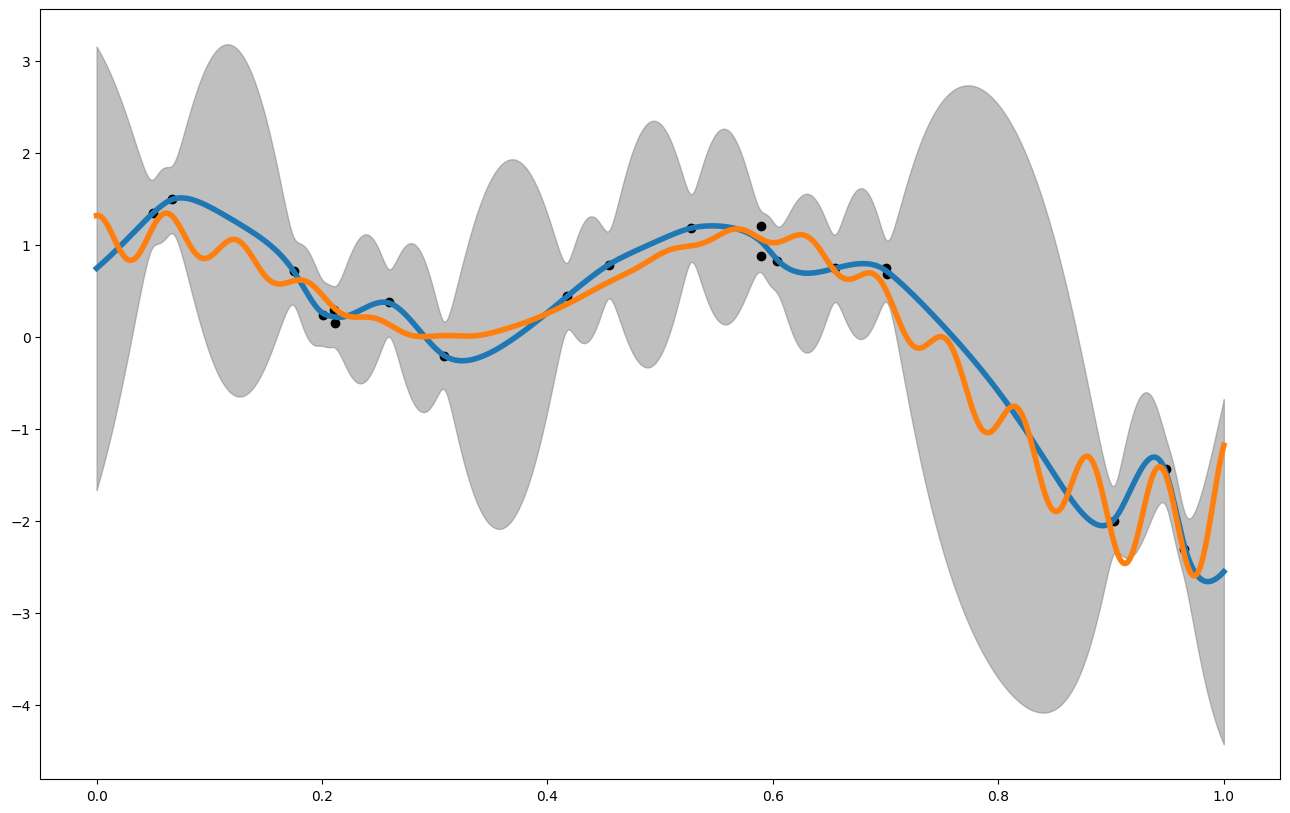

In [16]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gp1.rmse(x_pred1D,f1(x_pred1D).flatten()))
print(my_gp1.crps(x_pred1D,f1(x_pred1D).flatten()))

In [17]:
#We can ask mutual information and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print("Mutual Information: ",my_gp1.gp_mutual_information(x_test))
print("Total Correlation : ",my_gp1.gp_total_correlation(x_test))

Mutual Information:  {'x': array([[0.45],
       [0.45]]), 'mutual information': np.float64(2.77294721948428)}
Total Correlation :  {'x': array([[0.45],
       [0.45]]), 'total correlation': np.float64(12.970118955443596)}


In [18]:
next_point = my_gp1.ask(np.array([[0.,1.]]))
print(next_point)

{'x': array([[0.80217691]]), 'f_a(x)': array([1.03524959]), 'opt_obj': None}


## Running many GPs at once in parallel


In [19]:
#duplicate data: in practice, this would be different data in every column
y_data = np.broadcast_to(y_data[:, None], (y_data.size, 10))

my_gp1 = GPOptimizer(x_data,y_data,
            init_hyperparameters = np.ones((2))/10.,  # we need enough of those for kernel, noise, and prior mean functions
            noise_variances=np.ones(y_data.shape[0]) * 0.1, # providing noise variances and a noise function will raise a warning 
            compute_device='cpu',
            )


hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                      ])

print("Standard Training (MCMC)")
hps = my_gp1.train(hyperparameter_bounds=hps_bounds, info = True, max_iter = 100)
print("Result=", hps, "after ", time.time() - st, " seconds")
print("")

Standard Training (MCMC)
Starting likelihood. f(x)=  -32.32754030118298
Finished  10  out of  100  iterations. f(x)=  -14.823889093190532
Finished  20  out of  100  iterations. f(x)=  -14.823889093190532
Finished  30  out of  100  iterations. f(x)=  -14.19720045602294
Finished  40  out of  100  iterations. f(x)=  -14.926866233832873
Finished  50  out of  100  iterations. f(x)=  -14.835475866368744
Finished  60  out of  100  iterations. f(x)=  -17.243670401763545
Finished  70  out of  100  iterations. f(x)=  -15.422926542364191
Finished  80  out of  100  iterations. f(x)=  -14.196277507549535
Finished  90  out of  100  iterations. f(x)=  -14.206014390248164
Result= [2.08643493 0.26661938] after  140.28671646118164  seconds



In [20]:
x_pred = np.linspace(0,1,1000).reshape(1000,1)
mean = my_gp1.posterior_mean(x_pred)["m(x)"]
sd   = np.sqrt(my_gp1.posterior_covariance(x_pred)["v(x)"])

Posterior Means and Uncertainties


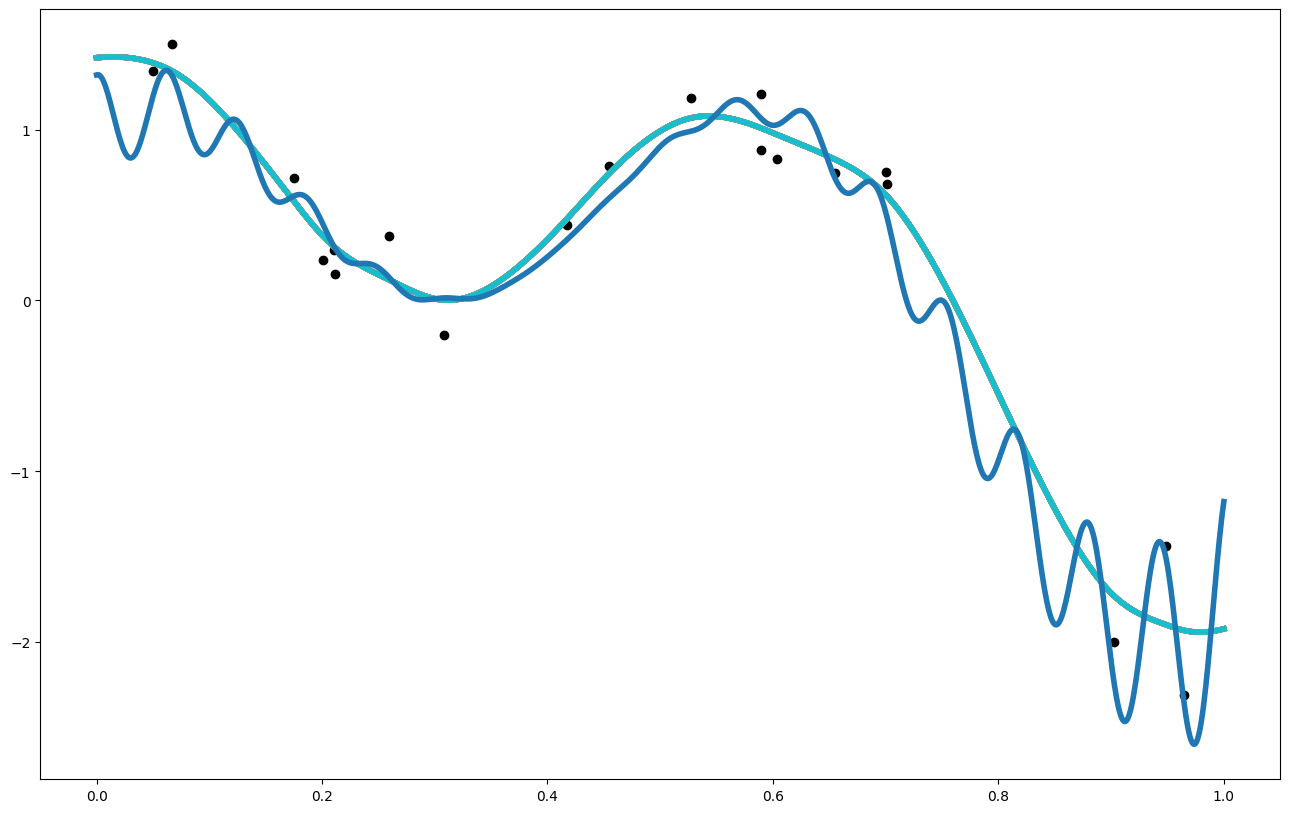

In [21]:
print("Posterior Means and Uncertainties")
plt.figure(figsize = (16,10))
for i in range(10):
    plt.plot(x_pred.flatten(),mean[:,i], label = "posterior mean", linewidth = 4)
plt.scatter(my_gp1.x_data,my_gp1.y_data[:,0], color = 'black')
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.show()